In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#获取训练集
def get_train_data(data, batch_size=60,time_step=20,train_begin=0,train_end=5800):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   #训练集 
    for i in range(len(normalized_train_data)-time_step):
       if i % batch_size==0:
           batch_index.append(i)
       x=normalized_train_data[i:i+time_step,:7]
       y=normalized_train_data[i:i+time_step,7,np.newaxis]
       train_x.append(x.tolist())
       train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

In [3]:
#获取测试集
def get_test_data(data,time_step=20,test_begin=5800):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #标准化
    size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample 
    test_x,test_y=[],[]  
    for i in range(size-1):
       x=normalized_test_data[i*time_step:(i+1)*time_step,:7]
       y=normalized_test_data[i*time_step:(i+1)*time_step,7]
       test_x.append(x.tolist())
       test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:7]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,7]).tolist())
    return mean,std,test_x,test_y

In [4]:
class NetConfig():
    def __init__(self):
        self.rnn_unit = 10
        self.input_size = 7
        self.output_size = 1
        self.lr = 0.0006
        self.time_step = 20
        self.batch_size = 80
        self.weights={
             'in':tf.Variable(tf.random_normal([self.input_size,self.rnn_unit])),
             'out':tf.Variable(tf.random_normal([self.rnn_unit,self.output_size]))
            }
        self.biases={
            'in':tf.Variable(tf.constant(0.1,shape=[self.rnn_unit,])),
            'out':tf.Variable(tf.constant(0.1,shape=[self.output_size,]))
           }

In [5]:
class MyModel():
    def __init__(self):
        self.sess = tf.Session()
        self.nc = NetConfig()
        #——————————————————训练模型——————————————————

    def train_rnn(self, data, save_path, iter_num):
        weights = self.nc.weights
        biases = self.nc.biases
        input_size = self.nc.input_size
        rnn_unit = self.nc.rnn_unit
        output_size = self.nc.output_size
        time_step = self.nc.time_step 
        batch_size = self.nc.batch_size
        lr = self.nc.lr
        sess = self.sess

        X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
        Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
        batch_index,train_x,train_y=get_train_data(data)
        pred,_ = self.rnn(X)
        #损失函数
        loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
        train_op=tf.train.AdamOptimizer(lr).minimize(loss)
        saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
        #module_file = tf.train.latest_checkpoint("check")    
        sess.run(tf.global_variables_initializer())
        #重复训练10000次
        total_loss = []
        for i in range(iter_num):
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
            total_loss.append(loss_)
            if i % 1==0:
                print("迭代第："+str(i)+ "次， Loss为：" + str(loss_))
            if i % 20==0:
                print("保存模型：",saver.save(sess,save_path,global_step=i))
        return total_loss
    


    #————————————————预测模型————————————————————
    def predict_rnn(self, data, model_path):
        weights = self.nc.weights
        biases = self.nc.biases
        input_size = self.nc.input_size
        rnn_unit = self.nc.rnn_unit
        output_size = self.nc.output_size
        time_step = self.nc.time_step 
        batch_size = self.nc.batch_size
        lr = self.nc.lr
        sess = self.sess
        
        X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
        #Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
        mean,std,test_x,test_y = get_test_data(data)
        pred,_ = self.rnn(X)     
        saver = tf.train.Saver(tf.global_variables())

        #参数恢复
        module_file = tf.train.latest_checkpoint(model_path)
        saver.restore(sess, module_file) 
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[7]+mean[7]
        test_predict=np.array(test_predict)*std[7]+mean[7]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差
        #以折线图表示结果
        return test_y,test_predict,acc    

    
    #————————————————预测模型————————————————————
    def predict_lstm(self, data, model_path):
        weights = self.nc.weights
        biases = self.nc.biases
        input_size = self.nc.input_size
        rnn_unit = self.nc.rnn_unit
        output_size = self.nc.output_size
        time_step = self.nc.time_step 
        batch_size = self.nc.batch_size
        lr = self.nc.lr
        sess = self.sess
        
        X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
        #Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
        mean,std,test_x,test_y = get_test_data(data)
        pred,_ = self.lstm(X)     
        saver = tf.train.Saver(tf.global_variables())

        #参数恢复
        module_file = tf.train.latest_checkpoint(model_path)
        saver.restore(sess, module_file) 
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[7]+mean[7]
        test_predict=np.array(test_predict)*std[7]+mean[7]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差
        #以折线图表示结果
        return test_y,test_predict,acc
    
    
    def lstm(self, X):
        weights = self.nc.weights
        biases = self.nc.biases
        input_size = self.nc.input_size
        rnn_unit = self.nc.rnn_unit
        output_size = self.nc.output_size
        time_step = self.nc.time_step 
        batch_size = self.nc.batch_size
        lr = self.nc.lr
        sess = self.sess
        
        batch_size=tf.shape(X)[0]
        time_step=tf.shape(X)[1]
        w_in=weights['in']
        b_in=biases['in']  
        input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
        input_rnn=tf.matmul(input,w_in)+b_in
        input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
        cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
        init_state=cell.zero_state(batch_size,dtype=tf.float32)
        output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
        output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
        w_out=weights['out']
        b_out=biases['out']
        pred=tf.matmul(output,w_out)+b_out
        return pred,final_states
    
    
    def train_lstm(self, data, save_path, iter_num):
        weights = self.nc.weights
        biases = self.nc.biases
        input_size = self.nc.input_size
        rnn_unit = self.nc.rnn_unit
        output_size = self.nc.output_size
        time_step = self.nc.time_step 
        batch_size = self.nc.batch_size
        lr = self.nc.lr
        sess = self.sess
        
        X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
        Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
        batch_index,train_x,train_y=get_train_data(data)
        pred,_ = self.lstm(X)
        #损失函数
        loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
        train_op=tf.train.AdamOptimizer(lr).minimize(loss)
        saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
        #module_file = tf.train.latest_checkpoint("check")    
        sess.run(tf.global_variables_initializer())
        #重复训练10000次
        total_loss = []
        for i in range(iter_num):
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
            total_loss.append(loss_)
            if i % 10==0:
                print("迭代第："+str(i)+ "次， Loss为：" + str(loss_))
            if i % 20==0:
                print("保存模型：",saver.save(sess,save_path,global_step=i))
        return total_loss

    def rnn(self, X):
        weights = self.nc.weights
        biases = self.nc.biases
        input_size = self.nc.input_size
        rnn_unit = self.nc.rnn_unit
        output_size = self.nc.output_size
        time_step = self.nc.time_step 
        batch_size = self.nc.batch_size
        lr = self.nc.lr
        sess = self.sess

        batch_size=tf.shape(X)[0]
        time_step=tf.shape(X)[1]
        w_in=weights['in']
        b_in=biases['in']  
        input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
        input_rnn=tf.matmul(input,w_in)+b_in
        input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
        cell=tf.nn.rnn_cell.BasicRNNCell(rnn_unit)
        init_state=cell.zero_state(batch_size,dtype=tf.float32)
        output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
        output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
        w_out=weights['out']
        b_out=biases['out']
        pred=tf.matmul(output,w_out)+b_out
        return pred,final_states

In [6]:
def plot_train_loss(total_loss):
    plt.figure()
    plt.plot(list(range(len(total_loss))), total_loss, color='b')
    plt.show()
    
def plot_predict(test_y, test_predict):
    plt.figure()
    plt.plot(list(range(len(test_predict))), test_predict, color='b')
    plt.plot(list(range(len(test_y))), test_y,  color='r')
    plt.show()

In [7]:
f=open('dataset_2.csv')
df=pd.read_csv(f)     #读入股票数据
data=df.iloc[:,2:10].values  #取第3-10

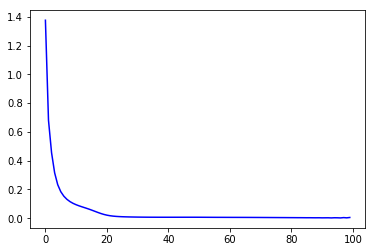

In [14]:
plot_train_loss(total_loss_lstm)

In [19]:
tf.reset_default_graph()
my_model = MyModel()
test_y,test_predict,accuracy = my_model.predict_rnn(data, "./stock_model/")

INFO:tensorflow:Restoring parameters from ./stock_model/model-80


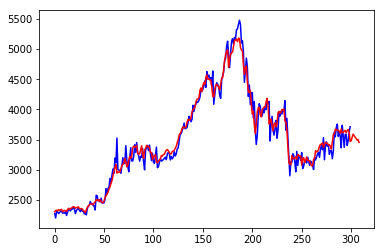

In [17]:
plot_predict(test_y, test_predict)